# Rossmann Store Sales - (Yibo) 
## Forecast sales using store, promotion, and competitor data

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

* [Step 1](#step1): Import data
* [Step 2](#step2): EDA
* [Step 3](#step3): Missing Value 
* [Step 4](#step4): Feature Selection
* [Step 5](#step5): Baseline model and test
* [Step 6](#step6): XGBoost model



In [1]:
# import libraries
#%pip install xgboost
import pandas as pd
import numpy as np
import xgboost as xgb

import missingno as msno
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

<a id='step1'></a>
## 1. Import Data
You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

### Files
* train.csv - historical data including Sales
* test.csv - historical data excluding Sales
* sample_submission.csv - a sample submission file in the correct format
* store.csv - supplemental information about the stores

In [2]:
# import data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
store = pd.read_csv('store.csv')

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Through ``DataFrame.info()``, we can find data type and missing values of each column DataFrame. We can find ``test.csv``and``store.csv``have missing values, which should be processed later.

In [3]:
train.info(), test.info(), store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date     

(None, None, None)

In [5]:
train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [4]:
test

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


<a id='step2'></a>
## 2. EDA

- When store is closed, daily sale must be 0.
- After dropping the data when store is closed, we then look at the distribution of daily sales. The distribution is obviously skewed with skewness as 1.594, much larger than 0.75, thus we should use log transformation later.

D:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


The skewness of Sales is 1.5939220392699809


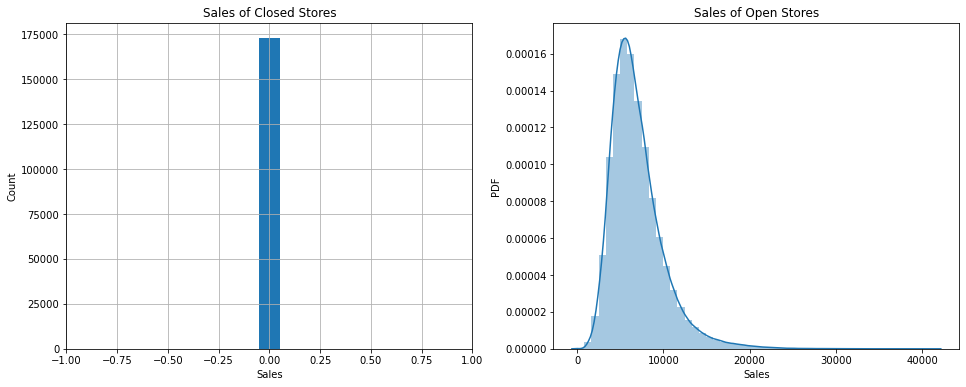

In [6]:
fig = plt.figure(figsize=(16,6))

ax1 = fig.add_subplot(121)
ax1.set_xlabel('Sales')
ax1.set_ylabel('Count')
ax1.set_title('Sales of Closed Stores')
plt.xlim(-1,1)
train.loc[train.Open==0].Sales.hist(align='left')

ax2 = fig.add_subplot(122)
ax2.set_xlabel('Sales')
ax2.set_ylabel('PDF')
ax2.set_title('Sales of Open Stores')
sns.distplot(train.loc[train.Open!=0].Sales)

print('The skewness of Sales is {}'.format(train.loc[train.Open!=0].Sales.skew()))

Thus, we only use open store data(Open!=0)for training. Besides, we won't use data with Sales==0.

In [7]:
train = train.loc[train.Open != 0]
train = train.loc[train.Sales > 0].reset_index(drop=True)

<a id='step3'></a>
## 3. Dealing with Missing Values

In [8]:
# train dataset missing values: no
train[train.isnull().values==True]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday


In [9]:
# test dataset missing values:
test[test.isnull().values==True]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


<AxesSubplot:>

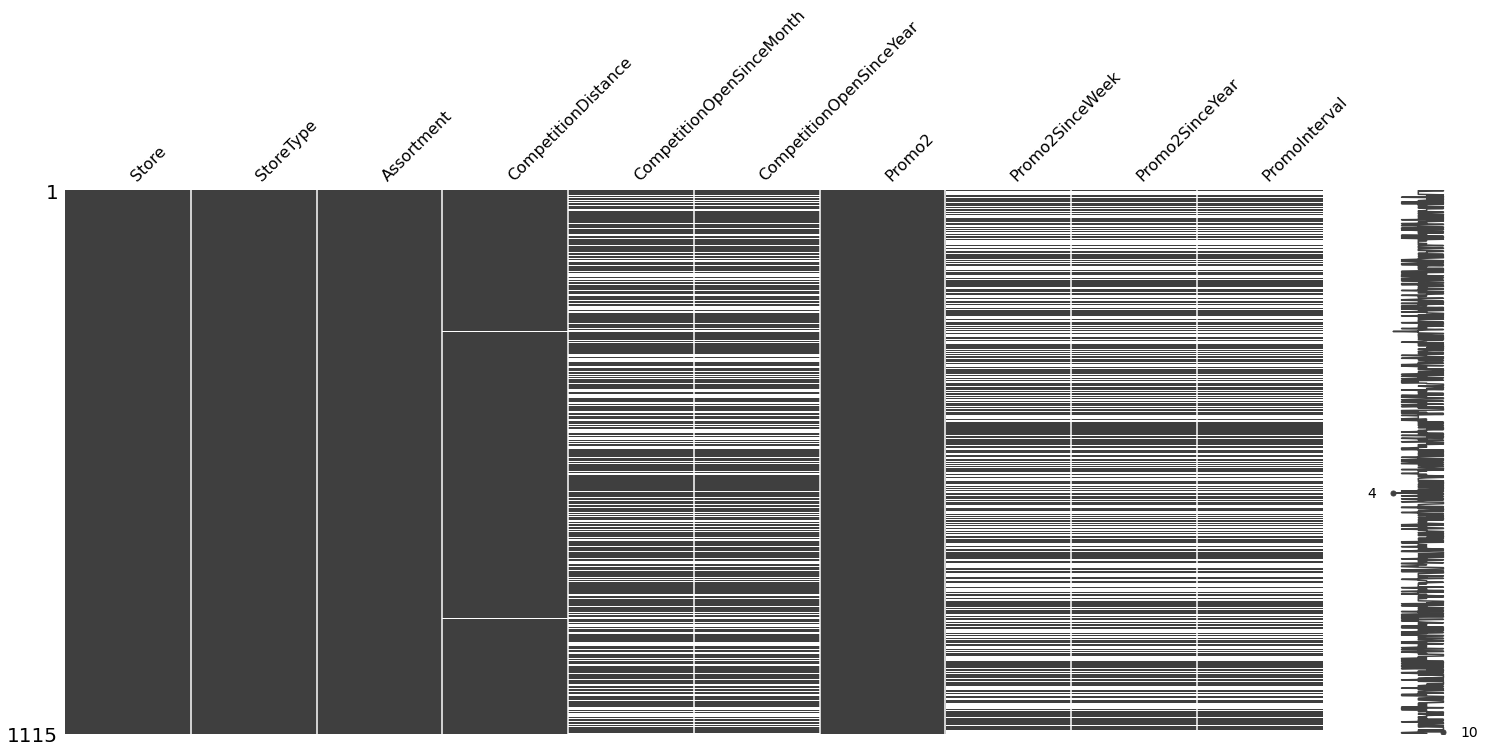

In [10]:
# store dataset missing values:
msno.matrix(store)

We can see missing info mainly exist on `test.csv` and `store.csv`. So we handle them, and then merge features.

In [11]:
# Assume all store in test dataset are open
test.fillna(1,inplace=True)

# Impute the missing values in CompetitionDistance using median
store.CompetitionDistance = store.CompetitionDistance.fillna(store.CompetitionDistance.median())

# impute other missing values with 0
store.fillna(0,inplace=True)

In [12]:
# Merge the features
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

<a id='step4'></a>
## 4. Feature Selection
### 4.1 Define function to extract features

In [13]:
def build_features(features, data):

    # Features that can be directly used 
    features.extend(['Store','CompetitionDistance','CompetitionOpenSinceMonth','StateHoliday','StoreType','Assortment',
                     'SchoolHoliday','CompetitionOpenSinceYear', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear'])
    
    # Ref：https://blog.csdn.net/aicanghai_smile/article/details/80987666
    
    # time features are processed using dt
    features.extend(['Year','Month','Day','DayOfWeek','WeekOfYear'])
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    # 'CompetitionOpen'：competitors' open time
    # 'PromoOpen'：competitors' promotion time
    # units of two features are 'month'
    features.extend(['CompetitionOpen','PromoOpen'])
    data['CompetitionOpen'] = 12*(data.Year-data.CompetitionOpenSinceYear) + (data.Month-data.CompetitionOpenSinceMonth)
    data['PromoOpen'] = 12*(data.Year-data.Promo2SinceYear) + (data.WeekOfYear-data.Promo2SinceWeek)/4.0
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    
    # 'IsPromoMonth'：if this store is in promption, 1 means yes, 0 means no
    features.append('IsPromoMonth')
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval==0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1
    
    # transform char to number 
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    data['StoreType'] = data['StoreType'].astype(int)
    data['Assortment'] = data['Assortment'].astype(int)
    data['StateHoliday'] = data['StateHoliday'].astype(int)

### 4.2 Feature Selection

In [14]:
# handle Date for better select features
train.Date = pd.to_datetime(train.Date, errors='coerce')
test.Date = pd.to_datetime(test.Date, errors='coerce')

# use 'features' list to store used features使用features数组储存使用的特征
features = []

# select features of train and test
build_features(features, train)
build_features([], test)

# print the features we will use
print(features)

<ipython-input-13-c249f6eeadf0>:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data['WeekOfYear'] = data.Date.dt.weekofyear


['Store', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'StateHoliday', 'StoreType', 'Assortment', 'SchoolHoliday', 'CompetitionOpenSinceYear', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']


<a id='step5'></a>
## 5. Baseline model and test

### 5.1 Define evaluation function

Since we predict continuous values, regression model should be used. Submissions are evaluated on the Root Mean Square Percentage Error (RMSPE). The RMSPE is calculated as：
$${\rm RMSPE} = \frac{1}{n}\sqrt{\sum\limits_{i = 1}^n {{{\left( {\frac{{{y_i} - {{\hat y}_i}}}{{{y_i}}}} \right)}^2}}}$$
where y_i denotes the sales of a single store on a single day and yhat_i denotes the corresponding prediction. Any day and store with 0 sales is ignored in scoring.

In [15]:
# Evaluation function Rmspe
# Ref：https://www.kaggle.com/justdoit/xgboost-in-python-with-rmspe

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y-yhat)**2))
    return rmspe

def rmspe_xg(yhat, y):
    y = y.get_label()
    y = np.expm1(y)
    yhat = np.expm1(yhat)
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y-yhat)**2))
    return "rmspe", rmspe

def neg_rmspe(yhat, y):
    y = np.expm1(y)
    yhat = np.expm1(yhat)
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y-yhat)**2))
    return -rmspe

### 5.2 Baseline test

I use Sklearn `DecisionTreeRegressor` with k-fold cross validation and grid search. The main hyperparameter that should be tuned is max depth of tree - `max_depth`

<a id='question2'></a>

In [17]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.metrics import make_scorer

from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=2)

cv_sets = ShuffleSplit(n_splits=5, test_size=0.2)    
params = {'max_depth':range(10,40,2)}
scoring_fnc = make_scorer(neg_rmspe)

grid = GridSearchCV(regressor,params,scoring_fnc,cv=cv_sets)
grid = grid.fit(train[features], np.log1p(train.Sales))

DTR = grid.best_estimator_

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass scoring=make_scorer(neg_rmspe) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


KeyboardInterrupt: 

In [ ]:
# Show the best parameters
DTR.get_params()

In [16]:
# Create submission files
submission = pd.DataFrame({"Id": test["Id"], "Sales": np.expm1(DTR.predict(test[features]))})
submission.to_csv("benchmark.csv", index=False)

Public Score:`0.18423`，Private Score:`0.22081`

<a id='step6'></a>
## 6. XGBoost
### 6.1 Model parameters

- `eta`：learning_rate；
- `max_depth`：Maximum depth of a tree；
- `subsample`：Subsample ratio of the training instances；
- `colsample_bytree`：subsample ratio of columns when constructing each tree；
- `num_trees`

In [17]:
# tune the parameters here
params = {'objective': 'reg:squarederror',
          'eta': 0.02, #learning rate
          'max_depth': 10, #maximum depth of a tree
          'subsample': 0.5,
          'colsample_bytree': 0.5,
          'verbosity': 1,
          'seed': 1
          }
num_trees = 10000

### 6.2 Model training

In [18]:
# randomly divide train set and test set
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(train, test_size=0.2, random_state=2)

dtrain = xgb.DMatrix(X_train[features], np.log1p(X_train.Sales))
dvalid = xgb.DMatrix(X_test[features], np.log1p(X_test.Sales))
dtest = xgb.DMatrix(test[features])

watchlist = [(dtrain, 'train'),(dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=50, feval=rmspe_xg, verbose_eval=False)

### 6.3 Create submission file

In [20]:
# Create submission file
test_probs = gbm.predict(xgb.DMatrix(test[features]), ntree_limit=gbm.best_ntree_limit)
indices = test_probs < 0
test_probs[indices] = 0
#submission = pd.DataFrame({"Id": test["Id"], "Sales": np.expm1(test_probs)})
submission = pd.DataFrame({"Id": test["Id"], "Sales": np.expm1(test_probs)*0.985})
submission.to_csv("xgboost.csv", index=False)

Public Score:`0.10932`，Private Score:`0.11750`，reaching the bronze medal line `0.11773`。